In [47]:
import numpy as np
import pandas as pd

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from datetime import datetime
from dateutil.relativedelta import relativedelta

import pyproj


import descartes
%matplotlib inline
import matplotlib.pyplot as plt

import shapely
import contextily as cx

import open_cp.data
import open_cp.geometry
import open_cp.plot
import matplotlib.collections
import open_cp.kernels

import sepp.sepp_grid
import datetime

from tqdm import tqdm

In [130]:
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [56]:
#read in crime data and clean
crime = pd.read_csv('2018LAcrime.csv')
crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M:%S'))
crime = crime[(crime['DATE OCC'].dt.year == 2018)]
crime = crime[~((crime.LAT==0)&(crime.LON==0))]

In [57]:
data = crime[['DATE OCC', 'LAT', 'LON']]
#data = data[(data['DATE OCC'].dt.year == 2018)]
data.columns = ['date', 'y', 'x']
xcoords, ycoords = crime.LON, crime.LAT
timestamps = crime['DATE OCC']

#la map
frame = gpd.read_file('/Users/annieulichney/Desktop/PredPolAnnie/County_Boundary.geojson')
geo = list(frame.geometry)[3]

#projected version
frame_proj = frame.to_crs(epsg=3857)
geo_proj = list(frame_proj.geometry)[3]

#project the coordinates
proj = pyproj.Proj({"init":"EPSG:3857"})
xcoords_proj, ycoords_proj = proj(crime['LON'].values, crime['LAT'].values)

#make grid on projected version

grid_proj = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=0, yoffset=0)
grid_proj = open_cp.geometry.mask_grid_by_intersection(geo_proj, grid_proj)

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [51]:
data.head()

,date,y,x
44931,2018-06-01 12:00:00,34.1436,-118.3953
44989,2018-10-03 12:00:00,33.9781,-118.4644
45075,2018-02-13 12:00:00,34.0188,-118.2684
45104,2018-05-05 12:00:00,34.2455,-118.4177
173613,2018-11-25 12:00:00,34.0654,-118.2941


In [63]:
max(crime['DATE OCC'])

Timestamp('2018-12-31 12:00:00')

In [68]:
crime = crime.reset_index(drop = True)

In [69]:
preds_vec = []
for i in tqdm(range(crime.shape[0])):
    this_crime = crime.loc[i]
    xproj, yproj = proj(this_crime.LON, this_crime.LAT)

    file_path = this_crime['DATE OCC'].strftime("%Y-%m-%d")
    temp_grid = pd.read_csv('grids/' + file_path + '.csv', header = None)

    grid_x, grid_y = grid_proj.grid_coord(xproj, yproj)

    preds_vec.append(temp_grid[grid_y][grid_x])

In [71]:
data.head()

,date,y,x
44931,2018-06-01 12:00:00,34.1436,-118.3953
44989,2018-10-03 12:00:00,33.9781,-118.4644
45075,2018-02-13 12:00:00,34.0188,-118.2684
45104,2018-05-05 12:00:00,34.2455,-118.4177
173613,2018-11-25 12:00:00,34.0654,-118.2941


In [72]:
data['lambda'] = preds_vec

<ipython-input-72-e9c48e2662e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lambda'] = preds_vec


In [75]:
data.head()

,date,y,x,lambda
44931,2018-06-01 12:00:00,34.1436,-118.3953,0.334248
44989,2018-10-03 12:00:00,33.9781,-118.4644,0.000000
45075,2018-02-13 12:00:00,34.0188,-118.2684,0.035616
45104,2018-05-05 12:00:00,34.2455,-118.4177,0.054795
173613,2018-11-25 12:00:00,34.0654,-118.2941,0.071233


In [74]:
data.to_csv('intervention_data.csv')

In [76]:
#read in crime data and clean
crime = pd.read_csv('2018LAcrime.csv')
crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M:%S'))
#crime = crime[(crime['DATE OCC'].dt.year == 2018)|(crime['DATE OCC'].dt.year == 2017)]
crime = crime[~((crime.LAT==0)&(crime.LON==0))]



#get info on which days we are going to be  training
start_timestamp = '2018-01-01 00:00:00'
start_timestamp = datetime.datetime.strptime(start_timestamp, '%Y-%m-%d %H:%M:%S')

print('Crime from ' , len(np.unique(crime[crime['DATE OCC'] >= start_timestamp]['DATE OCC'])), ' unique days')

all_dates_to_train = sorted(np.unique(crime[crime['DATE OCC'] >= start_timestamp]['DATE OCC']))



#project the coordinates
proj = pyproj.Proj({"init":"EPSG:3857"})

#make grid on projected coordinates
grid_proj = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=0, yoffset=0)
grid_proj = open_cp.geometry.mask_grid_by_intersection(geo_proj, grid_proj)
store_grid_proj = open_cp.plot.lines_from_grid(grid_proj)

#initialize dictionary in which to store the trained model from each day
pred_dic = dict.fromkeys(all_dates_to_train)



Crime from  365  unique days


/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [77]:
max(all_dates_to_train)

numpy.datetime64('2018-12-31T12:00:00.000000000')

Training for  2018-12-31  with data from  2017-12-31 to  2018-12-30


/Users/annieulichney/Desktop/PredPolAnnie/sepp/sepp_grid.py:370: RuntimeWarning: divide by zero encountered in double_scalars
  return over / under
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


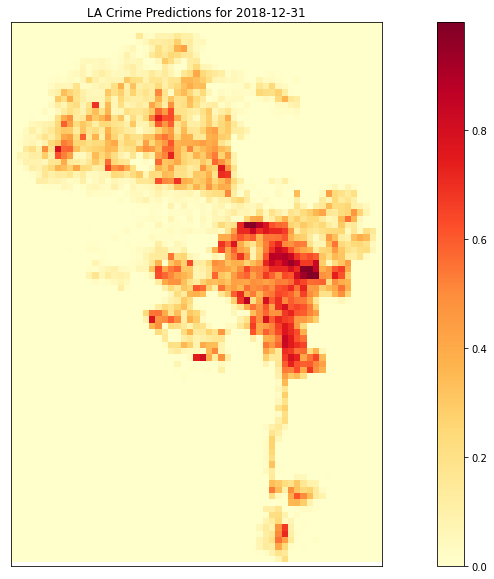

In [79]:


#calculate window of interest in which to train model for the given day we're looking at here
train_date = max(all_dates_to_train)
one_year_prior = pd.Timestamp(train_date) - pd.DateOffset(years = 1) #we follow moehler and use the prior year to train
crime_subset = crime[(crime['DATE OCC'] < train_date) & (crime['DATE OCC'] >= one_year_prior)]

day_string = np.datetime_as_string(train_date, unit = 'D')
min_day_string =  np.datetime_as_string(np.datetime64(min(crime_subset['DATE OCC'])), unit = 'D')
max_day_string = np.datetime_as_string(np.datetime64(max(crime_subset['DATE OCC'])), unit = 'D')

print('Training for ', day_string, ' with data from ', min_day_string, 'to ', max_day_string)

#project points within the window of interest
xcoords_proj, ycoords_proj = proj(crime_subset['LON'].values, crime_subset['LAT'].values)
timestamps = crime_subset['DATE OCC']
points_proj = open_cp.data.TimedPoints.from_coords(timestamps, xcoords_proj, ycoords_proj)

#train the data
trainer = sepp.sepp_grid.ExpDecayTrainer(grid_proj)
trainer.data = points_proj

#predict for the date of interest
model = trainer.train(train_date)
pred = trainer.prediction_from_background(model)

#store in dictionary
pred_dic[train_date] = pred.intensity_matrix

#save figure of the plotted intensity matrix
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
ax.set_aspect(1)

off = 1000
factor = 1


mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="YlOrRd", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("LA Crime Predictions for " + str(day_string))
None
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.xticks([])
plt.yticks([])
plot_title = np.datetime_as_string(train_date, unit = 'D')
#plt.savefig('ETAS_plots/' + plot_title + '.png')
plt.show()

In [ ]:
data = data.reset_index(drop = True)

In [88]:
data

,date,y,x,lambda
44931,2018-06-01 12:00:00,34.1436,-118.3953,0.334248
44989,2018-10-03 12:00:00,33.9781,-118.4644,0.000000
45075,2018-02-13 12:00:00,34.0188,-118.2684,0.035616
45104,2018-05-05 12:00:00,34.2455,-118.4177,0.054795
173613,2018-11-25 12:00:00,34.0654,-118.2941,0.071233
...,...,...,...,...
460495,2018-01-06 12:00:00,33.9345,-118.2623,0.000000
460496,2018-03-23 12:00:00,34.0782,-118.3614,0.306850
460497,2018-03-23 12:00:00,34.1400,-118.2190,0.139726
460498,2018-02-24 12:00:00,34.1208,-118.2320,0.060274


In [92]:
print('Mean : ', np.mean(data['lambda']))
print('Median : ', np.median(data['lambda']))
print('Min : ', np.min(data['lambda']))
print('Max : ', np.max(data['lambda']))
print('Std : ', np.std(data['lambda']))

Mean :  0.1777065502514873
Median :  0.0958905111455821
Min :  0.0
Max :  0.9981109983555037
Std :  0.20527767390689833


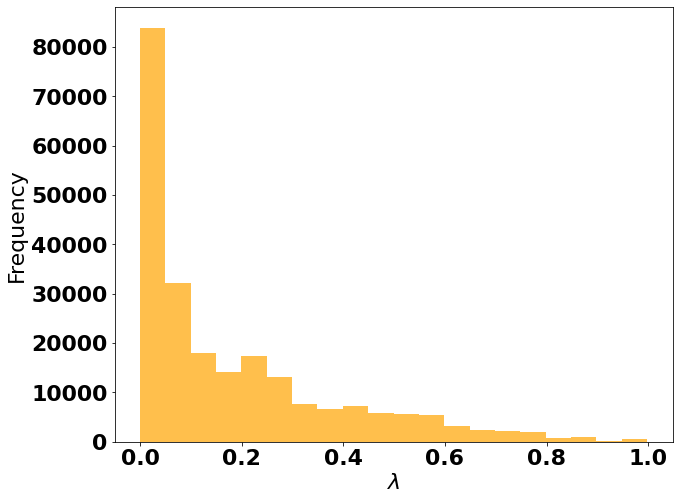

In [117]:
num_bins = 20
fig, ax = plt.subplots(figsize=(10,8))
n, bins, patches = plt.hist(data['lambda'], num_bins, facecolor='orange', alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('$\lambda$')
#plt.title(r'Histogram of $\lambda$ values for each crime in training data')
plt.show()

In [118]:
#recall that the lambda value is the proxy for crime being found on accident
#low means we should upweight that particular crime
#high means we should downweight it

beta_1 = 0.001
alpha_1 = np.mean(data['lambda']) + np.std(data['lambda'])

beta_2 = 0.001
alpha_2 = np.mean(data['lambda']) - 0.75*np.std(data['lambda'])

print('Above alpha_1 threshold: ', data[data['lambda'] >= alpha_1].shape[0]/data.shape[0])
print('Below alpha_2 threshold: ', data[data['lambda'] <= alpha_2].shape[0]/data.shape[0])



Above alpha_1 threshold:  0.16864315819785858
Below alpha_2 threshold:  0.30952380952380953


In [124]:
new_grid1 = pred.intensity_matrix.copy()

for i in tqdm(range(data.shape[0])):
    this_crime = data.loc[i]
    xproj, yproj = proj(this_crime.x, this_crime.y)

    grid_x, grid_y = grid_proj.grid_coord(xproj, yproj)

    this_lambda = data['lambda'][i]

    #check if above threshold, decrement the value in the square if so 
    if this_lambda >= alpha_1: 
        new_grid1[grid_y][grid_x]-= beta_1
    if this_lambda <= alpha_2: 
        new_grid1[grid_y][grid_x]+= beta_2

100%|██████████| 229194/229194 [01:01<00:00, 3726.63it/s]


In [128]:
def plot_intensity(grid_input):
    #save figure of the plotted intensity matrix
    fig, ax = plt.subplots(figsize=(20,10))
    ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
    ax.set_aspect(1)
    off = 1000
    factor = 1

    mappable = ax.pcolor(*pred.mesh_data(), grid_input, cmap="YlOrRd", rasterized=True)
    fig.colorbar(mappable, ax=ax)
    #ax.set_title("LA Crime Predictions Adjusted" )
    None
    plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
    plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
    plt.xticks([])
    plt.yticks([])
    #plot_title = np.datetime_as_string(train_date, unit = 'D')
    #plt.savefig('ETAS_plots/' + plot_title + '.png')
    plt.show()


/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


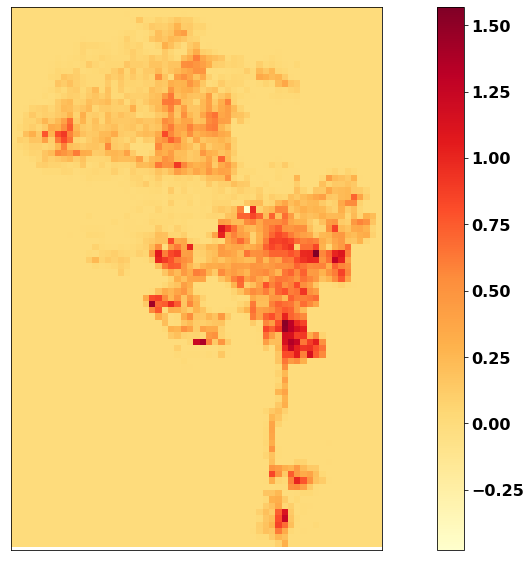

In [132]:
plot_intensity(new_grid1)

In [133]:
#recall that the lambda value is the proxy for crime being found on accident
#low means we should upweight that particular crime
#high means we should downweight it

beta_1 = 0.001
alpha_1 = np.mean(data['lambda']) + np.std(data['lambda'])

beta_2 = 0.00
alpha_2 = np.mean(data['lambda']) - 0.75*np.std(data['lambda'])

print('Above alpha_1 threshold: ', data[data['lambda'] >= alpha_1].shape[0]/data.shape[0])
print('Below alpha_2 threshold: ', data[data['lambda'] <= alpha_2].shape[0]/data.shape[0])



Above alpha_1 threshold:  0.16864315819785858
Below alpha_2 threshold:  0.30952380952380953


In [134]:
new_grid2 = pred.intensity_matrix.copy()

for i in tqdm(range(data.shape[0])):
    this_crime = data.loc[i]
    xproj, yproj = proj(this_crime.x, this_crime.y)

    grid_x, grid_y = grid_proj.grid_coord(xproj, yproj)

    this_lambda = data['lambda'][i]

    #check if above threshold, decrement the value in the square if so 
    if this_lambda >= alpha_1: 
        new_grid2[grid_y][grid_x]-= beta_1
    if this_lambda <= alpha_2: 
        new_grid2[grid_y][grid_x]+= beta_2

100%|██████████| 229194/229194 [01:09<00:00, 3283.26it/s]


/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


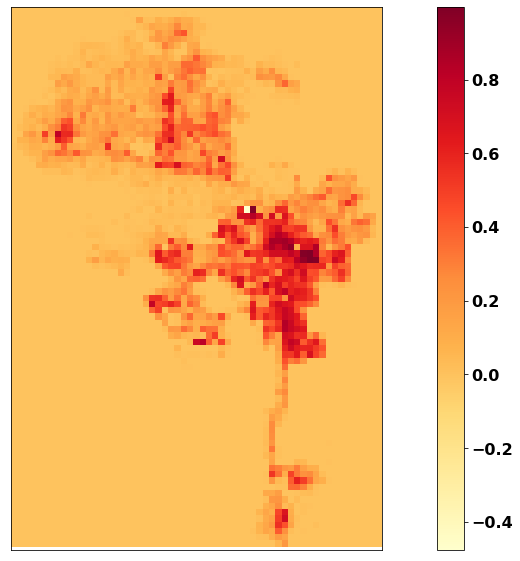

In [135]:
plot_intensity(new_grid2)

  0%|          | 316/229194 [00:00<01:12, 3157.69it/s]

Above alpha_1 threshold:  0.16864315819785858
Below alpha_2 threshold:  0.30952380952380953


100%|██████████| 229194/229194 [01:03<00:00, 3630.25it/s]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


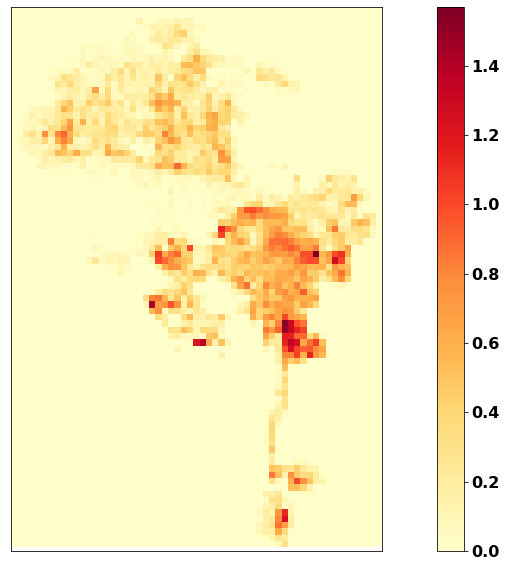

In [136]:
#recall that the lambda value is the proxy for crime being found on accident
#low means we should upweight that particular crime
#high means we should downweight it

beta_1 = 0.00
alpha_1 = np.mean(data['lambda']) + np.std(data['lambda'])

beta_2 = 0.001
alpha_2 = np.mean(data['lambda']) - 0.75*np.std(data['lambda'])

print('Above alpha_1 threshold: ', data[data['lambda'] >= alpha_1].shape[0]/data.shape[0])
print('Below alpha_2 threshold: ', data[data['lambda'] <= alpha_2].shape[0]/data.shape[0])

new_grid3 = pred.intensity_matrix.copy()

for i in tqdm(range(data.shape[0])):
    this_crime = data.loc[i]
    xproj, yproj = proj(this_crime.x, this_crime.y)

    grid_x, grid_y = grid_proj.grid_coord(xproj, yproj)

    this_lambda = data['lambda'][i]

    #check if above threshold, decrement the value in the square if so 
    if this_lambda >= alpha_1: 
        new_grid3[grid_y][grid_x]-= beta_1
    if this_lambda <= alpha_2: 
        new_grid3[grid_y][grid_x]+= beta_2

plot_intensity(new_grid3)



In [ ]:
#save figure of the plotted intensity matrix
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
ax.set_aspect(1)
off = 1000
factor = 1

mappable = ax.pcolor(*pred.mesh_data(), new_grid1, cmap="YlOrRd", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("LA Crime Predictions Adjusted" )
None
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.xticks([])
plt.yticks([])
plot_title = np.datetime_as_string(train_date, unit = 'D')
#plt.savefig('ETAS_plots/' + plot_title + '.png')
plt.show()

In [81]:
data.shape[0]

229194

In [ ]:
new_grid1 = pred.intensity_matrix.copy()